In [1]:
from influxdb import InfluxDBClient
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from datetime import datetime, timedelta
from dateutil.parser import parse

In [2]:
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'VirtualBuilding')
q = 'SELECT * FROM "VirtualBuilding"."autogen"."meters_and_sensors" WHERE time<now()'
df_raw = pd.DataFrame(client.query(q).get_points())  # Returns all points

In [3]:
df_raw

,time,location,node,value
0,2017-01-01T01:00:00Z,VirtualBuilding,power_cooling,0.000000
1,2017-01-01T01:00:00Z,VirtualBuilding,power_electricity,0.610739
2,2017-01-01T01:00:00Z,VirtualBuilding,power_heating,0.000000
3,2017-01-01T01:00:00Z,VirtualBuilding,t_in,14.053807
4,2017-01-01T01:00:00Z,VirtualBuilding,t_out,0.925000
...,...,...,...,...
121782,2018-12-26T22:00:00Z,VirtualBuilding,t_in,17.269158
121783,2018-12-26T22:00:00Z,VirtualBuilding,t_out,2.275000
121784,2018-12-26T22:00:00Z,VirtualBuilding,temp_diff,14.994158
121785,2018-12-26T22:00:00Z,VirtualBuilding,total_power,16.819279


In [4]:
df_piv = df_raw.pivot(index='time', columns='node', values=['value'])
df_piv.dropna(inplace=True)
df_piv

value                                             \
node                 power_cooling power_electricity power_heating       t_in   
time                                                                            
2017-01-01T01:00:00Z           0.0          0.610739      0.000000  14.053807   
2017-01-01T02:00:00Z           0.0          0.610739      0.000000  13.498118   
2017-01-01T03:00:00Z           0.0          0.610739      0.221951  13.159769   
2017-01-01T04:00:00Z           0.0          0.610739      1.160487  12.922441   
2017-01-01T05:00:00Z           0.0          0.610739      2.092721  12.756649   
...                            ...               ...           ...        ...   
2018-12-26T18:00:00Z           0.0          6.002527     19.100090  16.926280   
2018-12-26T19:00:00Z           0.0          6.002527     18.342074  17.069383   
2018-12-26T20:00:00Z           0.0         11.521435     16.380770  17.163298   
2018-12-26T21:00:00Z           0.0         11.521435     16.568495  17.227555   
2018-12-26T22:00:00Z           0.0         11.521435     16.819279  17.269158   

                                                    
node                  t_out  temp_diff total_power  
time                                                
2017-01-01T01:00:00Z  0.925  13.128807    0.000000  
2017-01-01T02:00:00Z  0.650  12.848118    0.000000  
2017-01-01T03:00:00Z  0.850  12.309769    0.221951  
2017-01-01T04:00:00Z  0.975  11.947441    1.160487  
2017-01-01T05:00:00Z  1.000  11.756649    2.092721  
...                     ...        ...         ...  
2018-12-26T18:00:00Z  5.250  11.676280   19.100090  
2018-12-26T19:00:00Z  4.250  12.819383   18.342074  
2018-12-26T20:00:00Z  3.550  13.613298   16.380770  
2018-12-26T21:00:00Z  2.950  14.277555   16.568495  
2018-12-26T22:00:00Z  2.275  14.994158   16.819279  

[17398 rows x 7 columns]

In [5]:
# importing csv
#data = pd.read_csv('/home/ict4bd/Desktop/Project/data_output/simulation_Data_1Year.csv',sep=',',decimal=',',index_col=0, low_memory=False)
cols = [i for i in df_piv.columns if i !="time"]

for col in cols:
    # converting to float
    df_piv[col] = df_piv[col].astype(float)

In [6]:
df_piv = df_piv.droplevel(0,axis=1)
df_piv = df_piv.rename_axis(None)

In [7]:
df_piv

node,power_cooling,power_electricity,power_heating,t_in,t_out,temp_diff,total_power
2017-01-01T01:00:00Z,0.0,0.610739,0.000000,14.053807,0.925,13.128807,0.000000
2017-01-01T02:00:00Z,0.0,0.610739,0.000000,13.498118,0.650,12.848118,0.000000
2017-01-01T03:00:00Z,0.0,0.610739,0.221951,13.159769,0.850,12.309769,0.221951
2017-01-01T04:00:00Z,0.0,0.610739,1.160487,12.922441,0.975,11.947441,1.160487
2017-01-01T05:00:00Z,0.0,0.610739,2.092721,12.756649,1.000,11.756649,2.092721
...,...,...,...,...,...,...,...
2018-12-26T18:00:00Z,0.0,6.002527,19.100090,16.926280,5.250,11.676280,19.100090
2018-12-26T19:00:00Z,0.0,6.002527,18.342074,17.069383,4.250,12.819383,18.342074
2018-12-26T20:00:00Z,0.0,11.521435,16.380770,17.163298,3.550,13.613298,16.380770
2018-12-26T21:00:00Z,0.0,11.521435,16.568495,17.227555,2.950,14.277555,16.568495


In [8]:
time = []
for i in range(len(df_piv.index)):
    # reading  index
    t = df_piv.index[i]
    t_datetime = parse(t)
    timestamp=t_datetime.strftime("%Y/%m/%d  %H:%M:%S")
    # splitting day and hour
    #day, hour = t.split('  ')
    time.append(timestamp)
df_piv.index = pd.to_datetime(time)
df_piv

node,power_cooling,power_electricity,power_heating,t_in,t_out,temp_diff,total_power
2017-01-01 01:00:00,0.0,0.610739,0.000000,14.053807,0.925,13.128807,0.000000
2017-01-01 02:00:00,0.0,0.610739,0.000000,13.498118,0.650,12.848118,0.000000
2017-01-01 03:00:00,0.0,0.610739,0.221951,13.159769,0.850,12.309769,0.221951
2017-01-01 04:00:00,0.0,0.610739,1.160487,12.922441,0.975,11.947441,1.160487
2017-01-01 05:00:00,0.0,0.610739,2.092721,12.756649,1.000,11.756649,2.092721
...,...,...,...,...,...,...,...
2018-12-26 18:00:00,0.0,6.002527,19.100090,16.926280,5.250,11.676280,19.100090
2018-12-26 19:00:00,0.0,6.002527,18.342074,17.069383,4.250,12.819383,18.342074
2018-12-26 20:00:00,0.0,11.521435,16.380770,17.163298,3.550,13.613298,16.380770
2018-12-26 21:00:00,0.0,11.521435,16.568495,17.227555,2.950,14.277555,16.568495


In [9]:
##input: data to be plotted, title of the graph
def plotting(dat,tit):
    # model for regression
    model = sm.OLS(dat.total_power,sm.add_constant(dat.temp_diff))
    # fitting the model
    results = model.fit()
    # plotting
    plt.figure()
    plt.plot(dat.temp_diff,results.predict(),'r', linewidth=1, label='regression')
    plt.scatter(dat.temp_diff,dat.total_power, s=5, label='observations')
    plt.xlabel('deltaT [C]')
    plt.ylabel('Energy Consumption [kWh]')
    plt.title(tit)
    plt.ylim(-0.1)
    plt.legend()

In [10]:
#%% SPLITTING DATA IN HOURLY, WEEKLY AND DAILY
# frequency conversion according to hour
dataH = df_piv.resample('H').mean()
# removing missing values
dataH = dataH.dropna()
# frequency conversion according to day
dataD = df_piv.resample('D').mean()
# removing missing values
dataD = dataD.dropna()
# frequency conversion according to week
dataW = df_piv.resample('W').mean()
# removing missing values
dataW = dataW.dropna()
# frequency conversion according to month
dataM = df_piv.resample('M').mean()
# removing missing values
dataM = dataM.dropna()

DIVIDING DATA IN SUMMER AND WINTER

In [11]:
data=df_piv
dataSum = []
dataWint = []
for i in range(len(data.index)):
    t = data.index[i]
    temp = {'t_in':data.t_in[i],'t_out':data.t_out[i], 'temp_diff':data.temp_diff[i], 'power_heating':data.power_heating[i], 'power_cooling':data.power_cooling[i],'power_electricity':data.power_electricity[i], 'total_power':data.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataSum.append(temp)
    else:
        dataWint.append(temp)
dataSum = pd.DataFrame.from_dict(dataSum)
dataWint = pd.DataFrame.from_dict(dataWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - month
dataMSum = []
dataMWint = []
for i in range(len(data.index)):
    t = data.index[i]
    temp = {'t_in':data.t_in[i],'t_out':data.t_out[i], 'temp_diff':data.temp_diff[i], 'power_heating':data.power_heating[i], 'power_cooling':data.power_cooling[i],'power_electricity':data.power_electricity[i], 'total_power':data.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataMSum.append(temp)
    else:
        dataMWint.append(temp)
dataMS = pd.DataFrame.from_dict(dataMSum)
dataMW = pd.DataFrame.from_dict(dataMWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - hour
dataHSum = []
dataHWint = []
for i in range(len(dataH.index)):
    t = dataH.index[i]
    temp = {'t_in':dataH.t_in[i],'t_out':dataH.t_out[i], 'temp_diff':dataH.temp_diff[i], 'power_heating':dataH.power_heating[i], 'power_cooling':dataH.power_cooling[i],'power_electricity':dataH.power_electricity[i], 'total_power':dataH.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataHSum.append(temp)
    else:
        dataHWint.append(temp)
dataHS = pd.DataFrame.from_dict(dataHSum)
dataHW = pd.DataFrame.from_dict(dataHWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - week
dataWSum = []
dataWWint = []
for i in range(len(dataW.index)):
    t = dataW.index[i]
    temp = {'t_in':dataW.t_in[i],'t_out':dataW.t_out[i], 'temp_diff':dataW.temp_diff[i], 'power_heating':dataW.power_heating[i], 'power_cooling':dataW.power_cooling[i],'power_electricity':dataW.power_electricity[i], 'total_power':dataW.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataWSum.append(temp)
    else:
        dataWWint.append(temp)
dataWS = pd.DataFrame.from_dict(dataWSum)
dataWW = pd.DataFrame.from_dict(dataWWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - day
dataDSum = []
dataDWint = []
for i in range(len(dataD.index)):
    t = dataD.index[i]
    temp = {'t_in':dataD.t_in[i],'t_out':dataD.t_out[i], 'temp_diff':dataD.temp_diff[i], 'power_heating':dataD.power_heating[i], 'power_cooling':dataD.power_cooling[i],'power_electricity':dataD.power_electricity[i], 'total_power':dataD.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataDSum.append(temp)
    else:
        dataDWint.append(temp)
dataDS = pd.DataFrame.from_dict(dataDSum)
dataDW = pd.DataFrame.from_dict(dataDWint)

### REGRESSION (Ordinary Least Square) - winter

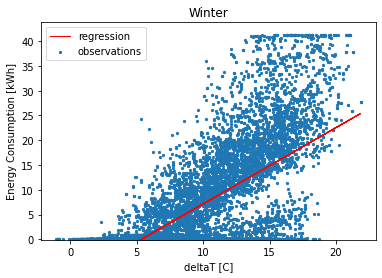

In [12]:
plotting(dataWint, 'Winter')

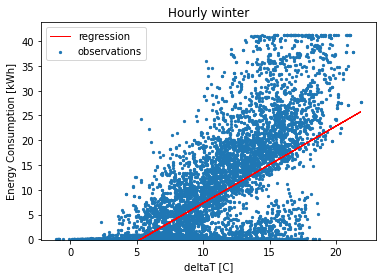

In [13]:
plotting(dataHW, 'Hourly winter')

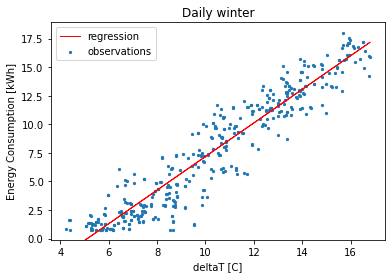

In [14]:
plotting(dataDW, 'Daily winter')

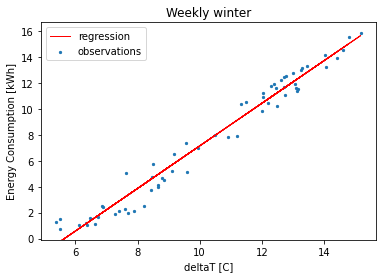

In [15]:
plotting(dataWW, 'Weekly winter')

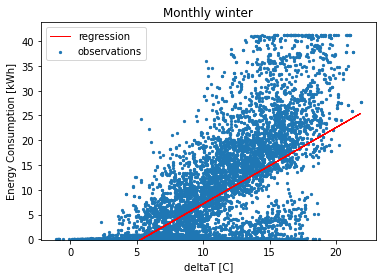

In [16]:
plotting(dataMW, 'Monthly winter')

### REGRESSION (Ordinary Least Square) - summer

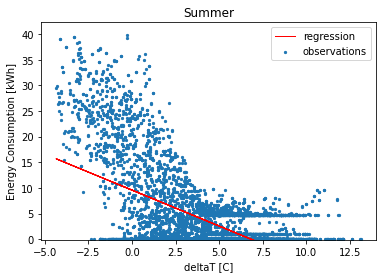

In [17]:
plotting(dataSum, 'Summer')

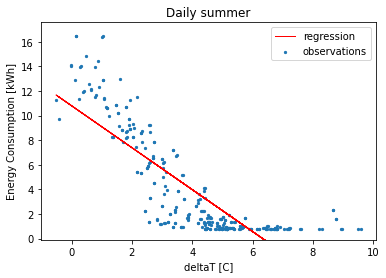

In [18]:
plotting(dataDS,'Daily summer')

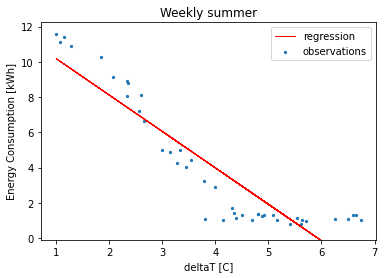

In [19]:
plotting(dataWS, 'Weekly summer')

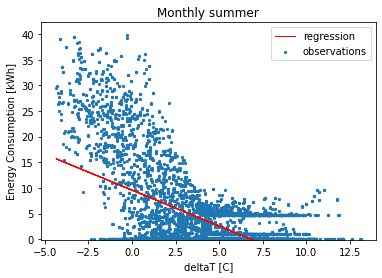

In [20]:
plotting(dataMS, 'Monthly summer')